In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False
import matplotlib.pyplot as plt
import copy
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
from pathlib import Path

In [2]:
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120
sns.set_style('white')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from lme.utils import *
from lme.plotting import *
from lme.classification import *
from lme.pathway_scoring import *

# Signatures

In [5]:
signatures = read_gene_sets('databases/signatures.gmt')
signatures

{'Lymphatic_endothelium': Lymphatic_endothelium (Lymphatic endothelium): SOX18,JAM2,PDPN,LYVE1,EDNRB,PPP1R13B,CXCL12,PROX1,FLT4,CXADR,CCL21,FOXC2,JAM3,
 'Angiogenesis': Angiogenesis (Angiogenesis): CXCL5,CDH5,ANGPT1,VEGFA,FLT1,KDR,PGF,CXCL8,CXCR2,TEK,VWF,VEGFB,ANGPT2,PDGFC,VEGFC,
 'CAF': CAF (Cancer Associated Fibroblasts): FN1,PTGS2,CA9,MMP12,COL6A1,MMP7,ACTA2,LUM,MFAP5,LGALS1,CD248,COL4A1,LGALS9,MMP2,COL11A1,COL6A2,COL6A3,TGFB1,CTGF,TIMP1,FAP,MMP3,FBLN1,TGFB3,S100A4,PRELP,COL5A1,LRP1,MMP9,COL1A1,COL1A2,FGF2,MMP1,TGFB2,
 'Fibroblastic_reticular_cells': Fibroblastic_reticular_cells (Fibroblastic reticular cells): ACTA2,DES,PDPN,VCAM1,ICAM1,PTGS2,THY1,NT5E,VIM,PDGFRA,LTBR,
 'Matrix': Matrix (Matrix): FN1,COL1A1,COL1A2,LGALS7,COL4A1,COL3A1,VTN,
 'Matrix_remodeling': Matrix_remodeling (Matrix remodeling): MMP9,TIMP2,CA9,MMP2,TIMP1,
 'Granulocyte_traffic': Granulocyte_traffic (Granulocyte traffic): CXCL5,CXCL2,CXCL1,CXCL8,CXCR2,KITLG,CCR3,CCL11,KIT,CXCR1,
 'Protumor_cytokines': Protumor_cy

In [6]:
signatures_selected = [
 'Lymphatic_endothelium',
 'Angiogenesis',
 'CAF',
 'Fibroblastic_reticular_cells',
 'Matrix',
 'Matrix_remodeling',
 'Granulocyte_traffic',
 'Protumor_cytokines',
 'Follicular_dendritic_cells',
 'Macrophages',
 'M1_signature',
 'T_cell_traffic',
 'MHCII',
 'MHCI',
 'Follicular_B_helper_T_cells',
 'Treg',
 'T_cells',
 'Checkpoint_inhibition',
 'NK_cells',
 'B_cells_traffic',
 'B_cells',
 'Proliferation_rate']
len(signatures_selected)

22

In [7]:
progeny_selected = ['NFkB', 'p53', 'PI3K']
len(progeny_selected)

3

<AxesSubplot:>

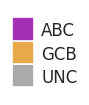

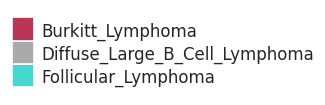

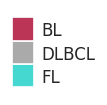

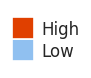

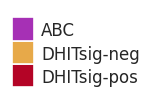

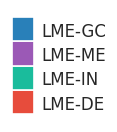

In [8]:
dlbcl_subtype_p = {'ABC': '#A630B5', 'GCB': '#E7A949', 'UNC': '#AAAAAA'}
patch_plot(dlbcl_subtype_p)

diagnosis_p = {'Burkitt_Lymphoma': '#BB3556',
         'Diffuse_Large_B_Cell_Lymphoma': '#AAAAAA',
         'Follicular_Lymphoma': '#44D8D1'}
patch_plot(diagnosis_p)
diagnosis_shortener = {'Diffuse_Large_B_Cell_Lymphoma': 'DLBCL', 'Follicular_Lymphoma': 'FL',
               'Burkitt_Lymphoma': 'BL'}
diagnosis_rn_p = {'BL': '#BB3556',
         'DLBCL': '#AAAAAA',
         'FL': '#44D8D1'}
patch_plot(diagnosis_rn_p)

high_low_p = {'High': '#E04000', 
              'Low': '#90C0F0'}
high_low_o = ['High', 'Low']
high_low_map = {True:'High',
                False: 'Low'}
patch_plot(high_low_p)

dhit_p = {'DHITsig-neg': dlbcl_subtype_p['GCB'], 'DHITsig-pos': '#b40426', 'ABC': dlbcl_subtype_p['ABC']}

patch_plot(dhit_p)

lme_o = ['LME-GC', 'LME-ME', 'LME-IN', 'LME-DE', ]
lme_p = {
            'LME-GC': '#2980B9',
            'LME-ME': '#9B59B6', 
            'LME-IN': '#1ABC9C', 
            'LME-DE': '#E74C3C',}

patch_plot(lme_p, order=lme_o)

# Read cohort

In [9]:
cohort_ann = read_dataset('datasets/pan_cohort_annotation.tsv')
cohort_ann.shape

(5116, 32)

In [10]:
cohort_ann.head()

,Cohort,Cohort_group,SORTN,COO_BG,COO_original,LME,DHITsig_predicted,DHITsig_original,Diagnosis,GenClass7,...,DLBCL90-Group,COO_RT,COO_Hans,Transformed_FL,series_ids,geo_accessions,dbGAP_id,ID1,ID2,platform_id
Sample,,,,,,,,,,,,,,,,,,,,,
GSM3302930,GSE117556,GSE117556,1,ABC,ABC,LME-ME,DHITsig-neg,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302930,NaN,RMDB_1,NaN,GPL14951
GSM3302931,GSE117556,GSE117556,2,GCB,GCB,LME-GC,DHITsig-neg,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302931,NaN,RMDB_2,NaN,GPL14951
GSM3302932,GSE117556,GSE117556,3,GCB,GCB,LME-GC,DHITsig-pos,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302932,NaN,RMDB_3,NaN,GPL14951
GSM3302933,GSE117556,GSE117556,4,ABC,ABC,LME-DE,DHITsig-neg,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302933,NaN,RMDB_4,NaN,GPL14951
GSM3302934,GSE117556,GSE117556,5,GCB,GCB,LME-ME,DHITsig-pos,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302934,NaN,RMDB_5,NaN,GPL14951


In [11]:
cohort_sign_sc = read_dataset('datasets/pan_cohort_signatures.tsv.gz').T
cohort_sign_sc.shape

(5116, 38)

In [12]:
cohort_sign_sc.head()

,EGFR,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,...,B_cells_traffic,Follicular_B_helper_T_cells,Th1_signature,T_cells,Checkpoint_inhibition,MHCII,MHCI,NK_cells,B_cells,Proliferation_rate
DLC0001,-1.100459,1.778296,-0.010550,0.370199,1.009720,-0.995537,0.312762,1.193305,0.933070,-1.007430,...,1.901869,4.907127,2.858243,1.984391,1.646320,0.214866,-0.519421,0.392673,0.138287,-2.709766
DLC0002,1.515182,2.768054,0.654394,2.370840,0.975191,-0.899303,1.767230,1.801683,1.415524,-1.277588,...,0.273988,-0.073384,-0.736010,0.176268,0.479735,-0.543240,-1.204911,0.021682,0.883285,0.618806
DLC0003,-0.855085,0.215444,2.023212,0.471082,1.987488,0.090416,-0.489591,0.438043,1.810002,-1.136433,...,-0.014866,1.135015,1.718405,2.099066,1.630966,0.098000,-1.170603,2.067505,-2.015865,-0.399773
DLC0004,1.170281,2.552209,1.924494,2.637014,1.168497,-2.202614,3.159769,1.717606,2.066829,-1.815582,...,-1.195651,0.289175,-0.450115,1.134542,-0.586538,0.067294,-0.608622,2.168512,-0.309114,-2.152889
DLC0005,-0.414280,0.536973,2.633446,0.993703,0.666727,-1.963422,1.470179,0.737218,2.252673,-1.626322,...,0.895766,3.279645,1.519968,1.882563,1.718104,0.507834,-0.551072,0.550601,0.164978,-1.908548


In [13]:
len(cohort_sign_sc.index & cohort_ann.index)

5116

<AxesSubplot:xlabel='PCA 1 component 28% variance explained', ylabel='PCA 2 component 13% variance explained'>

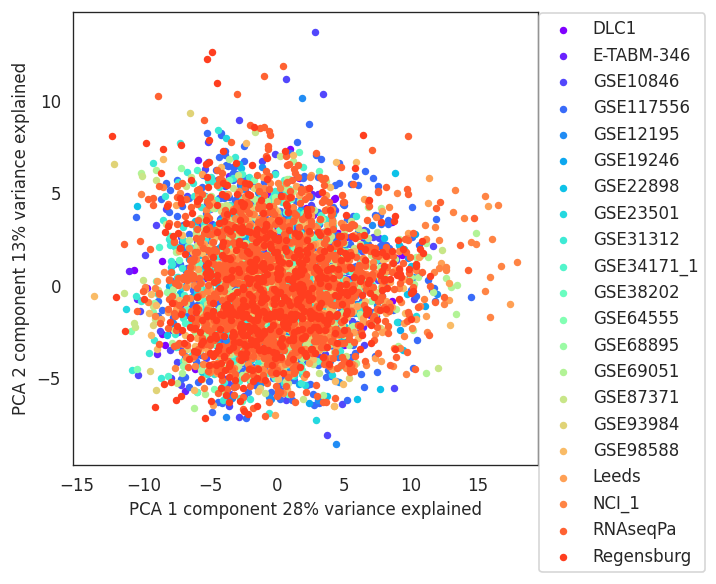

In [14]:
pca_plot(cohort_sign_sc, cohort_ann.Cohort_group, legend='out')

<AxesSubplot:xlabel='PCA 1 component 28% variance explained', ylabel='PCA 2 component 13% variance explained'>

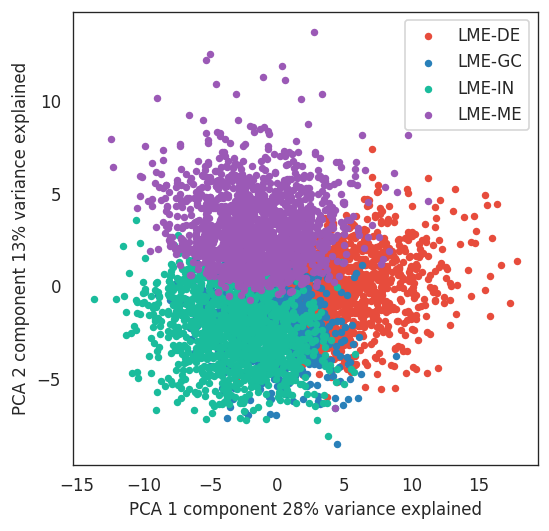

In [15]:
pca_plot(cohort_sign_sc, cohort_ann.LME.dropna(), palette=lme_p)

## Model

In [16]:
cohort_ann_filtered = cohort_ann[(cohort_ann.Diagnosis=='Diffuse_Large_B_Cell_Lymphoma') & 
                                 (~cohort_ann.LME.isna())]
cohort_ann_filtered.shape

(4656, 32)

In [17]:
LME_MODEL = KNeighborsClusterClassifier(norm=False, scale=False, clip=3, k=35).fit(
    *to_common_samples([cohort_sign_sc[signatures_selected + progeny_selected], cohort_ann_filtered.LME]))

# Classify example cohort: GSE56313

## Read expression

In [18]:
ann = read_dataset('datasets/GSE56313/annotation.tsv')
ann.shape

(55, 12)

In [19]:
ann.head()

,Patient,Cohort,Cohort_group,Diagnosis,BAGS_class,CD79B_Status,EZH2_Status,MYD88_Status,COO,COO_BG,DHITsig,platform_id
Sample,,,,,,,,,,,,
GSM1358939,H1,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centrocyte,WT,WT,WT,ABC,GCB,DHITsig-neg,GPL570
GSM1358940,H10,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Unclassified,NaN,WT,NaN,ABC,ABC,DHITsig-neg,GPL570
GSM1358941,H11,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centroblast,NaN,WT,WT,GCB,GCB,DHITsig-neg,GPL570
GSM1358942,H12,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centrocyte,WT,WT,WT,GCB,GCB,DHITsig-neg,GPL570
GSM1358943,H13,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centroblast,WT,WT,WT,ABC,ABC,DHITsig-neg,GPL570


Genes should be in columns, samples in rows  
Make sure it is log2 transformed one time (mean expressions should be between 0 and 18)

In [20]:
exp = np.log2(1+read_dataset('datasets/GSE56313/expressions.tsv.gz').T)

In [21]:
exp.head()

Gene_symbol,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AA06,...,ZYX,ZZEF1,ZZZ3,abParts,av27s1,hADV36S1,hsa-let-7a-3,hsa-let-7b,hsa-mir-4763,mir-223
GSM1358939,3.398629,3.229542,2.242460,8.975672,2.932449,2.340419,2.625855,4.157479,2.242557,2.410004,...,7.919923,7.535532,9.066579,4.544640,2.242722,2.411134,2.24246,2.24246,2.24246,4.002745
GSM1358940,2.242460,3.358790,2.242460,10.830553,3.451486,2.251113,2.242460,3.012059,2.242557,2.242460,...,8.337970,7.966719,9.343023,5.076570,2.242722,2.245702,2.24246,2.24246,2.24246,4.787586
GSM1358941,2.390763,3.895996,2.762986,9.225935,2.453358,2.242460,2.242460,3.308393,2.242557,2.517436,...,10.429838,8.965752,8.243231,4.823728,2.259413,2.587467,2.24246,2.24246,2.24246,4.002745
GSM1358942,2.390763,2.753845,2.242460,10.882917,2.980621,2.251113,2.242460,3.130747,2.242557,2.242460,...,8.937943,8.583962,8.718742,8.438893,2.242722,2.245702,2.24246,2.24246,2.24246,7.509161
GSM1358943,2.405299,3.218549,2.246557,9.335253,2.434799,2.435370,2.242460,3.539215,2.242557,2.242460,...,9.278991,7.003909,8.552902,5.163131,2.540013,3.346210,2.24246,2.24246,2.24246,5.609699


<AxesSubplot:ylabel='Density'>

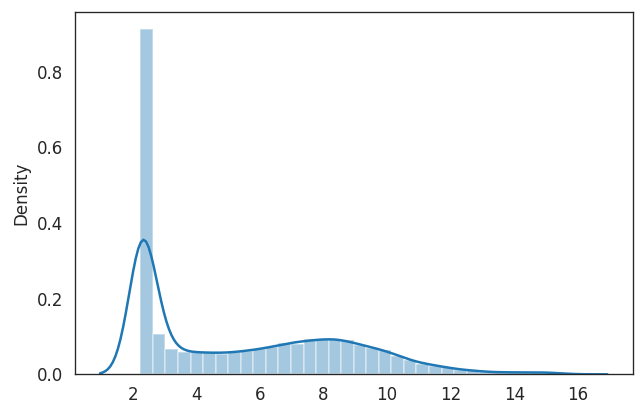

In [22]:
sns.distplot(exp.mean())

Check for batch effects

<AxesSubplot:xlabel='PCA 1 component 10% variance explained', ylabel='PCA 2 component 7% variance explained'>

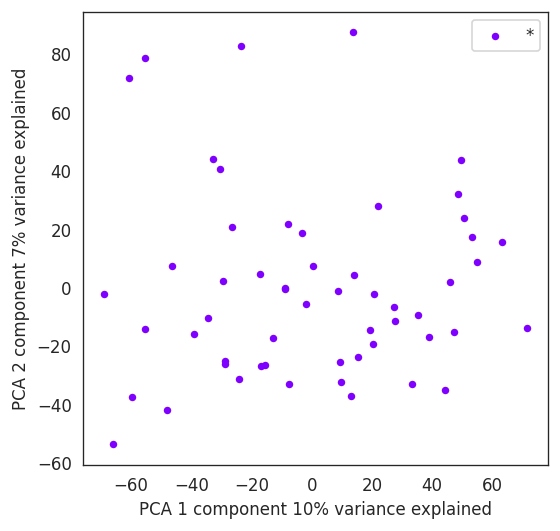

In [23]:
pca_plot(exp)

<AxesSubplot:xlabel='PCA 1 component 10% variance explained', ylabel='PCA 2 component 7% variance explained'>

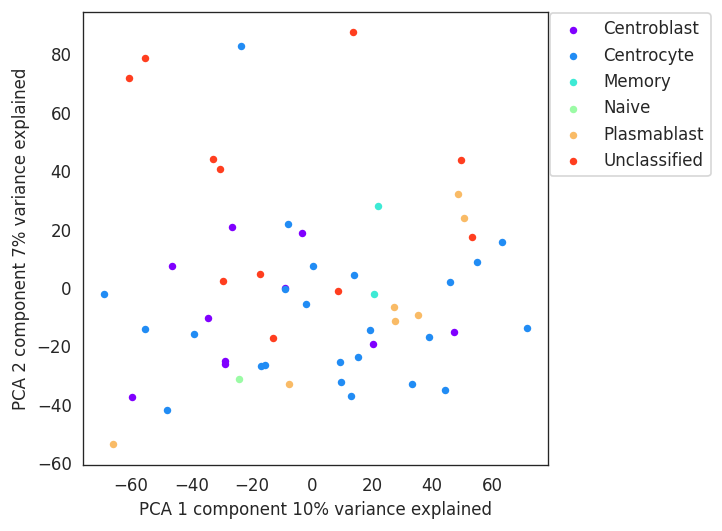

In [24]:
pca_plot(exp, ann.BAGS_class, legend='out')

## Calc signatures

Calculate ssgsea scores and progeny  
Concatenate them

In [25]:
sign = pd.concat([ssgsea_formula(exp, signatures), run_progeny(exp.T).T], axis=1)
sign.shape

(55, 41)

In [26]:
sign.head()

,Lymphatic_endothelium,Angiogenesis,CAF,Fibroblastic_reticular_cells,Matrix,Matrix_remodeling,Granulocyte_traffic,Protumor_cytokines,Follicular_dendritic_cells,Macrophages,...,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
GSM1358939,-160.876254,896.872755,3919.711386,3689.651433,5876.870836,5117.140715,-2061.804719,3645.144760,3993.136722,1754.957862,...,6079.960648,1095.099634,5896.664394,-2819.694663,1646.742262,5841.041201,121.156252,-351.990797,386.750766,3331.302776
GSM1358940,2185.034275,2575.990926,4826.591712,5182.149349,6670.413278,6930.909019,-301.631037,4075.105078,6624.723233,1939.012559,...,6579.714463,1069.881426,6011.486202,-2802.103041,1821.945534,6000.588490,114.289349,-362.913911,395.411393,3212.268411
GSM1358941,-440.063110,1277.589174,4691.090399,4818.726509,6714.593309,7485.075341,-2614.745564,3601.739387,5935.233492,114.513259,...,5488.651978,1279.928709,5633.632101,-2693.907177,1824.552162,5646.854135,96.903704,-324.242911,374.021116,3314.927354
GSM1358942,631.707180,1861.778047,6457.318986,5706.337687,7626.186603,8535.359424,-1466.839608,3701.799906,3746.375372,2354.974009,...,5765.952875,1236.627929,5777.963537,-2744.846346,2085.213090,5884.520618,66.714042,-435.153794,392.913515,3292.002922
GSM1358943,1217.914505,1565.561173,3574.439413,3625.067635,5339.923651,6208.988263,-1880.800201,3230.314962,6074.992741,313.402573,...,5829.559431,1096.409014,5416.434101,-2784.548138,1694.701682,5533.012806,89.985699,-298.601421,392.335983,3123.659088


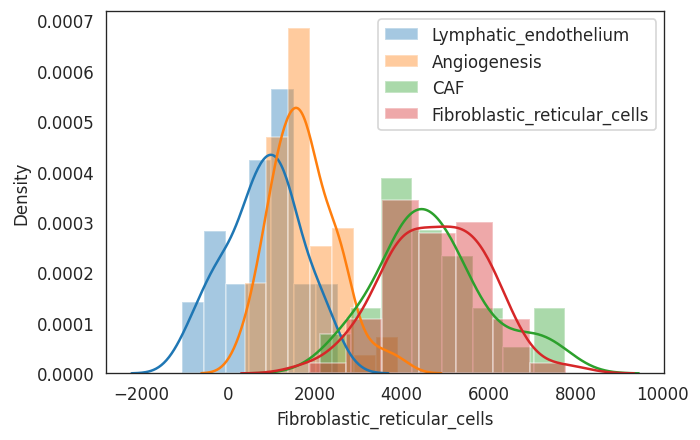

In [27]:
_, ax = plt.subplots(1, 1)
for i in sign.columns[:4]:
    sns.distplot(sign[i], label=i, ax=ax, kde=True)
ax.legend()

Scale signatures

In [28]:
sign_sc = median_scale(sign, 3)
sign_sc.shape

(55, 41)

In [29]:
sign_sc.head()

,Lymphatic_endothelium,Angiogenesis,CAF,Fibroblastic_reticular_cells,Matrix,Matrix_remodeling,Granulocyte_traffic,Protumor_cytokines,Follicular_dendritic_cells,Macrophages,...,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
GSM1358939,-1.436759,-1.344182,-0.747056,-1.252811,-0.827535,-1.515633,-0.178132,-0.583759,-1.941545,-0.344663,...,-1.159207,-1.039683,-0.225652,-0.463819,-1.096586,-0.261157,0.284551,0.067274,-1.032242,0.709379
GSM1358940,1.972933,1.578868,0.182446,0.337655,-0.049585,0.202221,1.554106,0.008779,0.264053,-0.183658,...,0.000000,-1.545051,0.083240,-0.191182,0.212244,0.211701,-0.116696,-0.211603,-0.332650,-0.582935
GSM1358941,-1.842546,-0.681422,0.043564,-0.049623,-0.006273,0.727082,-0.722297,-0.643577,-0.313825,-1.779664,...,-2.530780,2.664249,-0.933257,1.485650,0.231716,-0.836680,-1.132575,0.775703,-2.060522,0.531597
GSM1358942,-0.284769,0.335549,1.853851,0.896251,0.887409,1.721826,0.407390,-0.505681,-2.148362,0.180210,...,-1.887565,1.796511,-0.544979,0.696189,2.178944,-0.132295,-2.896619,-2.055953,-0.534425,0.282714
GSM1358943,0.567261,-0.180113,-1.100941,-1.321634,-1.353932,-0.481524,0.000000,-1.155446,-0.196689,-1.605683,...,-1.740026,-1.013444,-1.517560,0.080886,-0.738312,-1.174078,-1.536808,1.430353,-0.581077,-1.544936


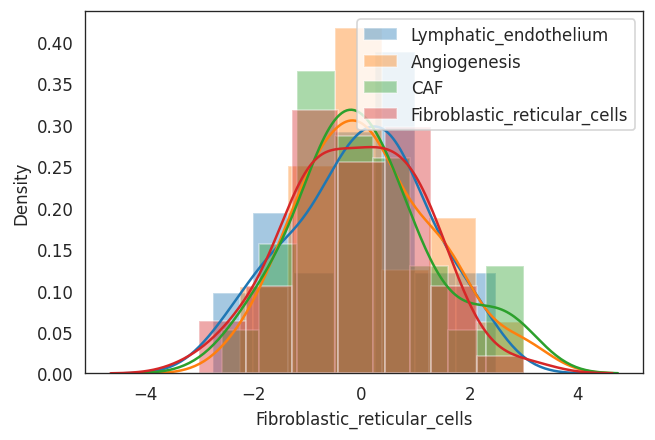

In [30]:
_, ax = plt.subplots(1, 1)
for i in sign_sc.columns[:4]:
    sns.distplot(sign_sc[i], label=i, ax=ax, kde=True)
ax.legend()

<AxesSubplot:xlabel='BAGS_class', ylabel='Follicular_dendritic_cells'>

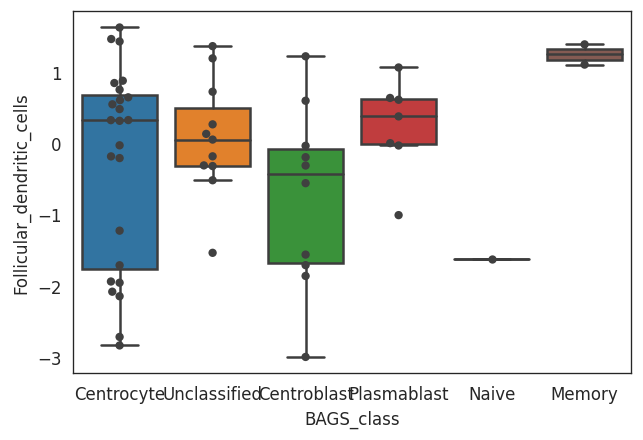

In [31]:
sns.boxplot(y=sign_sc.Follicular_dendritic_cells, x=ann.BAGS_class, fliersize=0)
sns.swarmplot(y=sign_sc.Follicular_dendritic_cells, x=ann.BAGS_class, s=5, color='.25')

<AxesSubplot:xlabel='BAGS_class', ylabel='Proliferation_rate'>

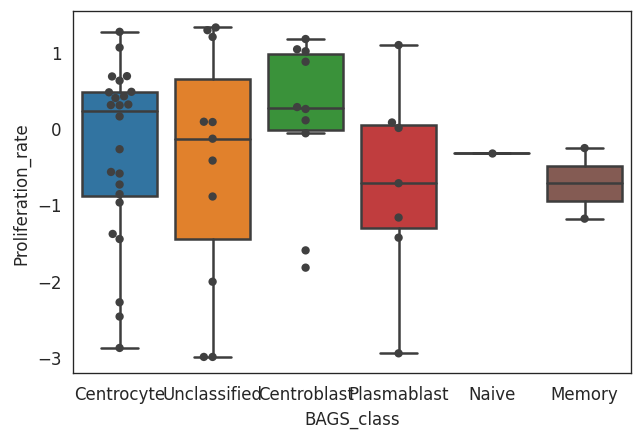

In [32]:
sns.boxplot(y=sign_sc.Proliferation_rate, x=ann.BAGS_class, fliersize=0)
sns.swarmplot(y=sign_sc.Proliferation_rate, x=ann.BAGS_class, s=5, color='.25')

## Classify

In [33]:
lme_predicted = LME_MODEL.predict(sign_sc[LME_MODEL.X.columns])

<AxesSubplot:>

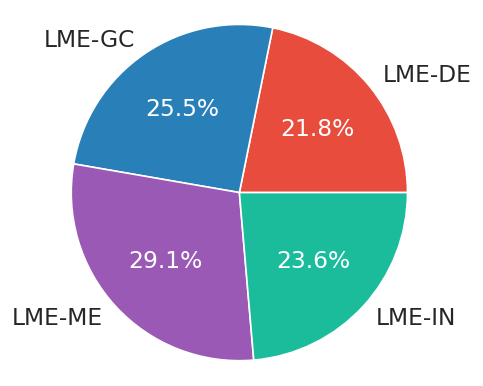

In [34]:
vector_pie_plot(lme_predicted, palette=lme_p)

In [35]:
pd.crosstab(ann.COO_BG, lme_predicted)[lme_o]

col_0,LME-GC,LME-ME,LME-IN,LME-DE
COO_BG,,,,
ABC,6,4,7,6
GCB,8,12,6,6


In [36]:
so = list(pd.concat([ann.COO_BG[ann.COO_BG==i] for i in ['GCB', 'ABC']]).index)
so = list(pd.concat([lme_predicted.loc[so][lme_predicted.loc[so]==i] for i in lme_o]).index)
len(so)

55

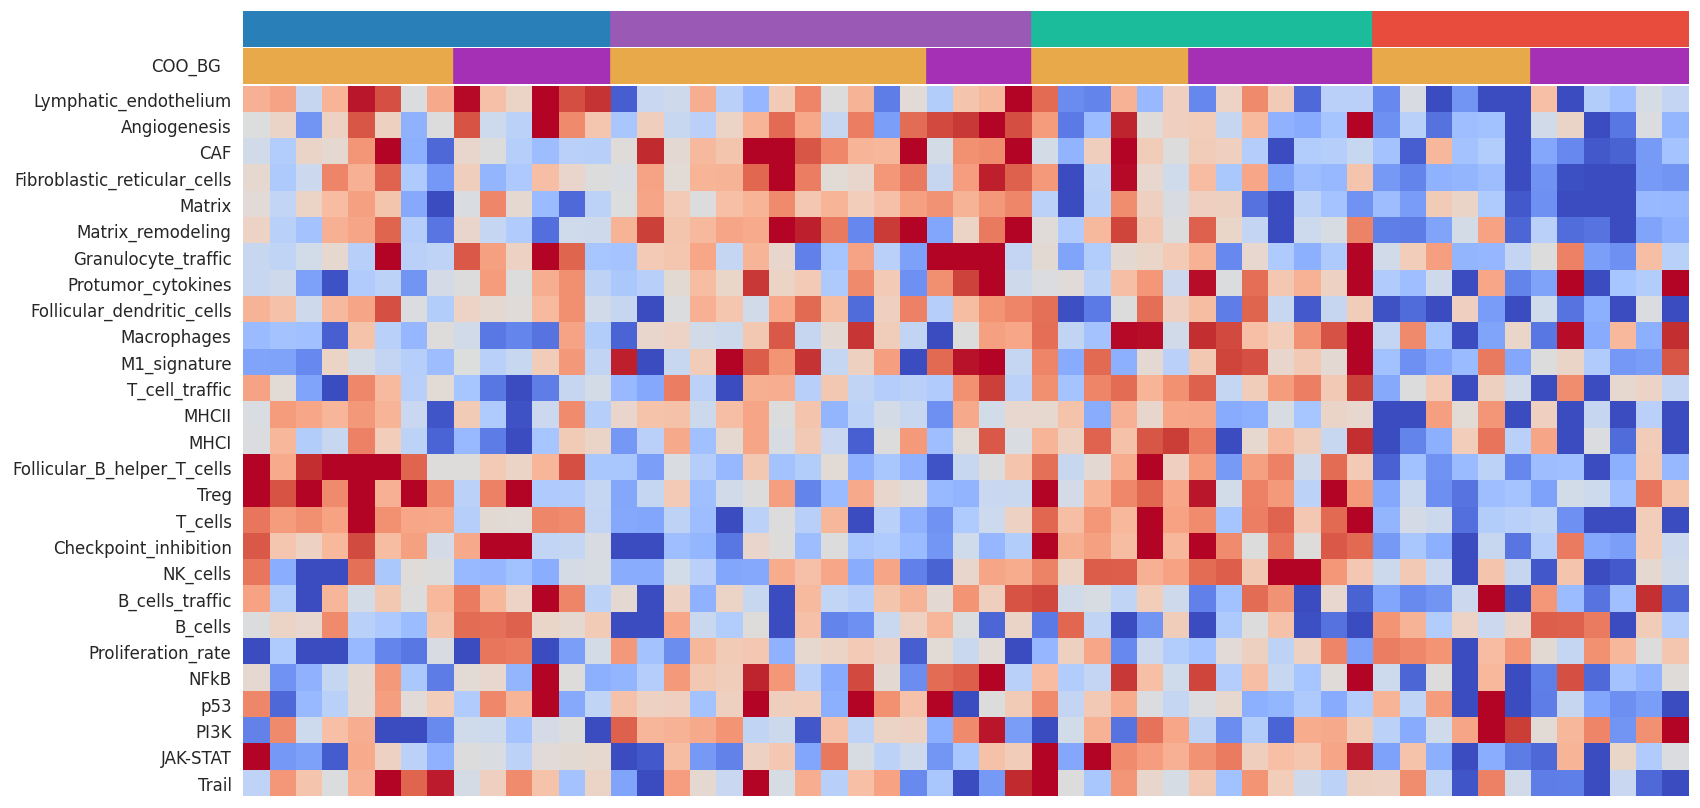

In [37]:
af = axis_matras([.3, .3, 6], x_len=14)

ax = next(af)
line_palette_annotation_plot(lme_predicted[so], ax=ax, palette=lme_p)

ax = next(af)
line_palette_annotation_plot(ann.COO_BG[so], ax=ax, palette=dlbcl_subtype_p)

ax = next(af)
sns.heatmap(sign_sc.loc[so, signatures_selected + progeny_selected + ['JAK-STAT', 'Trail']].clip(-2, 2).T,
            yticklabels=True, xticklabels=False, cbar=False, cmap=plt.cm.coolwarm, ax=ax)
plt.tight_layout(pad=.1)